
## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

##### 2 Représenter la distribution empirique des "fold-change" (**FC**) vs Précision, aka: volcano-plot
    
##### 3 Effectuer une analyse de sur-représentation en termes GO


## Ressources : Rappels et illustration de l'analyse de représentation de termes GO
###### [TP de MADP](https://github.com/glaunay/tp-proteomics#3-obtention-des-param%C3%A8tres-du-mod%C3%A8le)
###### [Fiche Bioconductor](https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html)



### Préparation de  l'environnement

##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [1]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Jeux de données
* Jeux de données de protéomique quantitative au format TSV
* Ontologie GO au format [owl](http://www.obofoundry.org/ontology/go.html)
* Entrées Uniprot au format XML
    * Protéines de l'étude
    * Protéome d'E.Coli complet
    
<hr style="border:1px solid gray"> </hr>

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ 
Retirer les lignes présentant des aberrations numériques
</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Attention aux types des colonnes !</span>

In [5]:
datatcl = pd.read_csv('../TCL_wt1.tsv', 
                      sep='\t', 
                      dtype={'Corrected Abundance ratio (1.53)':'float', 
                             'Log2 Corrected Abundance Ratio':'float', 
                             'Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)':'float', 
                             'LOG10 Adj.P-val':'float'
                            },
                      na_values=['#VALEUR!', 'NA', 'na', 'nan', 'NaN', ''])
print(datatcl.shape)
datatcl = datatcl.dropna()
print(datatcl.shape)
datatcl.head(3)

(2024, 7)
(1746, 7)


,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899


print(len(datatcl['Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)']))

print(len(datatcl[datatcl['Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)']<0.05]))

##### 1. Un premier volcano-plot

Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnée la précision de la mesure.

<span style="color:firebrick;font-weight:bold">$\rhd$ 1. Réaliser un scatter plot matplotlib avec</span>
<br/><span style="color:firebrick;font-weight:bold">- en x, `Log2 Corrected Abundance Ratio`</span>
<br/><span style="color:firebrick;font-weight:bold">-  en y, `LOG10 Adj.P-val`</span>

<span style="color:firebrick;font-weight:bold">$\rhd$Vous légenderez les axes, attention `LOG10 Adj.P-val` est en fait `-LOG10 Adj.P-val`, regardez bien.</span>

Text(0, 0.5, '-LOG10 Adj.P-val')

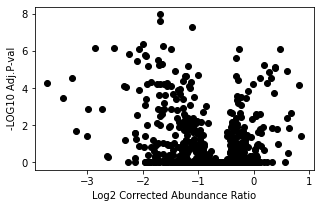

In [6]:
x = datatcl['Log2 Corrected Abundance Ratio']
y = datatcl['LOG10 Adj.P-val']

fig, ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
ax.scatter(x, y, c='k')
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

##### 2. Réaliser des versions évoluées du graphique précédent
L'objectif est de mettre l'accent sur la région **-Log10 adj Pvalue > 4** et **Log2 corrected abundance ratio > 0**.
<br/>Pour cela vous revisiterez le scatter plot précedent au travers des versions suivantes:
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ première version : un rectangle de la couleur de votre choix matérialisera la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ deuxième version  : une couleur de votre choix représentera les points de la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ troisème version (optionnel): Les identifiants uniprot remplaceront les points des protéines de la région</span>

In [7]:
import matplotlib.patches as patches

In [8]:
x_list = datatcl['Log2 Corrected Abundance Ratio'].to_list()
y_list = datatcl['LOG10 Adj.P-val'].to_list()

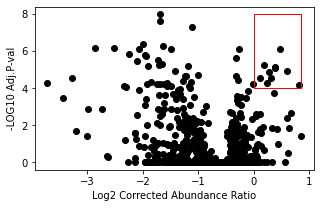

In [9]:
fig, ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
ax.scatter(x, y, c='k')
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

my_rect = patches.Rectangle(
    (0, 4),
    max(x), (max(y) - 4),
    linewidth=1,
    edgecolor='r',
    facecolor='none'
)
ax.add_patch(my_rect)

plt.show()

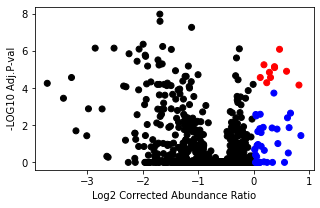

In [10]:
col = np.where(x > 0,np.where(y > 4,'r','b'),'k')

fig1, f1_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
f1_ax.scatter(x, y, c=col)
f1_ax.set_xlabel('Log2 Corrected Abundance Ratio')
f1_ax.set_ylabel('-LOG10 Adj.P-val')

plt.show()

In [11]:
for i, txt in enumerate(datatcl['Accession']):
    #print(max(datatcl['LOG10 Adj.P-val'].to_list()))
    if datatcl['LOG10 Adj.P-val'].to_list()[i] > 4 and datatcl['Log2 Corrected Abundance Ratio'].to_list()[i] > 0:
        print(i, txt)

1719 P0ACF8
1724 P62399
1726 P0A905
1728 P76506
1729 P13036
1733 P06971
1734 P0A910
1737 P06996
1739 P76344
1744 P02931


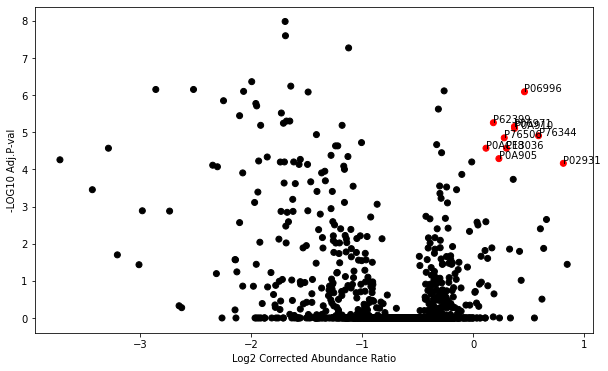

In [12]:
col = np.where(x > 0,np.where(y > 4,'r','k'),'k')

fig, ax = plt.subplots(figsize=(10,6), ncols=1, nrows=1)
ax.scatter(x, y, c=col)
ax.set_xlabel('Log2 Corrected Abundance Ratio')
ax.set_ylabel('-LOG10 Adj.P-val')

for i, txt in enumerate(datatcl['Accession']):
    if x_list[i] > 0 and y_list[i] > 4:
        #print(txt)
        ax.annotate(txt, (x_list[i], y_list[i]))

plt.show()

#### Analyse ORA

##### Principes
Vous disposez d'un objet analyser permettant de réaliser une analyse de la sur-représentation (**ORA**) en termes GO parmi une liste de protéine d'intérêt.
La fréquence des termes GO dans le protéome totale est utilisée comme référence.

L'objet analyser s'instancie ainsi
```python
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
```

Il fournit une méthode pour chaque catégorie de termes GO
<i>{ biological_process, molecular_function, cellular_component }</i>

Une éventuelle surreprésentation des termes GO de la catégorie <i>biological_process</i> est par exemple calculée parmi les protéines P29744 et P05706 de la façon suivante:

```python
goTerm_scores = o.biological_process(["P29744", "P05706"])
```
<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous.$\downarrow$ </span>
</br><span style="color:firebrick;font-weight:bold"> $\rhd$ Inspecter l'objet retourné par la méthode o.biological_process, que voyez-vous ?</span>

o = GO...
contiendra l'ontologie GO

en faisant o.biological_process([prots surexrimées])

il fait un test de Fisher

pour chaque terme GO, table de contingence : prots qui sont dans le terme et les autres X prots abondantes et prots non abondantes

-> itérable : (p-valeur, nom GO, terme GO, protéines membres)

ordonner par p-valeur, tri par nb de membres, choix : p-val remarquable avec un gd nombre de membres pour les colorier ou non
scatterplot : colorier les membres du terme GO 'xxx'

df.loc['FC' >= 0.16]['Accession']

In [13]:
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")

Loading ontology
Loaded
Reading whole proteome
4391 Loaded
reading experimental protein set
2024 Loaded


In [14]:
goTerm_scores = o.biological_process(["P29744", "P05706"])

Building biological process GO Tree
Extracting biological process ontology
Applying true path collapsing
8 GO terms, 2 leaves, 2 proteins
Extracting biological process ontology
Applying true path collapsing
2728 GO terms, 6650 leaves, 3128 proteins
Evaluated 7 / 7 Pathways, based on 2 proteins


In [15]:
for go in goTerm_scores:
    print(go)

(0.03359505459610164, 'bacterial-type flagellum-dependent cell motility', 'GO:0071973', ['P29744'])
(0.03485155369413595, 'archaeal or bacterial-type flagellum-dependent cell motility', 'GO:0097588', ['P29744'])
(0.03673476977601661, 'phosphoenolpyruvate-dependent sugar phosphotransferase system', 'GO:0009401', ['P05706'])
(0.03798922545382319, 'cell motility', 'GO:0048870', ['P29744'])
(0.04312840804902765, 'localization', 'GO:0051179', ['P29744', 'P05706'])
(1.0, 'biological_process', 'GO:0008150', ['P29744', 'P05706'])


Les protéines semblent être impliquées dans la motilité cellulaire via le flagelle.

###### 2/ Analyser la représentation des termes GO parmi les protéines surabondantes de l'experience
<span style="color:firebrick;font-weight:bold"> $\rhd$ Vous devrez extraire les identifiants uniprot des protéines aux `Log2 Corrected Abundance Ratio` supérieurs au seuil alpha de 5%.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous conduirez sur cette liste de protéines une analyse de sur-représentation en termes GO à l'aide d'un objet *GO_ORA_analyser*.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous pouvez faire varier le seuil d'abondance autour de la valeur alpha.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous traiterez les 3 catégories *biological_process / molecular_function /cellular_component*.</span>



Familiarisez-vous avec la structures des dictionnaires de résultas, vous pouvez [les sauvegarder au format json](https://docs.python.org/3/library/json.html).


In [16]:
datatcl.head(1)

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067


x_list = datatcl['Log2 Corrected Abundance Ratio'].to_list()

y_list = datatcl['LOG10 Adj.P-val'].to_list()

In [17]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

s = datatcl['Log2 Corrected Abundance Ratio'].to_list()
pdf_by_gaussian = gaussian_kde(s)
# dataset : fold change

def find_alpha(f, integr_ratio, dataset):
    positive = True
    negative = False
    MAX_ITER = 50
    integr_tot = quad(f, float('-inf'), float('inf'))[0] # ~= 1
    dx = 10**(2)
    x = min(dataset)
    
    for step in range(0, MAX_ITER):
        integr_step = quad(f, x, float('inf'))[0] # partie droite de la courbe
        S = integr_step/integr_tot # intégrale actuelle / 1
        
        # update dx abs value
        if S > integr_ratio: # dx is positive
            # on est en-dessous du seuil
            positive = True
            if negative:
                negative = False
                dx = dx * 0.5
            x = x + dx
        else: # dx is negative
            # on est au-dessus du seuil
            negative = True
            if positive:
                positive = False
                dx = dx * 0.5
            x = x - dx
    return x

p = 0.05
x_seuil = find_alpha(pdf_by_gaussian, p, datatcl['Log2 Corrected Abundance Ratio'].to_list())
print(f"Threshold for {int(p*100)} %:", round(x_seuil, 3))

Threshold for 5 %: -0.096


In [18]:
df = datatcl[['Accession', 'Log2 Corrected Abundance Ratio', 'LOG10 Adj.P-val']]
interest = df.loc[df['Log2 Corrected Abundance Ratio']>x_seuil]
acc_interest = [acc for acc in interest['Accession'].to_list()]
print(len(acc_interest), 'proteins of interest:', acc_interest[:3], '...')

67 proteins of interest: ['P39831', 'P0AG78', 'P0A9H1'] ...


## Une première application: représentation riche du résultat de l'analyse


### Mise en forme "riche" des résultats grâce au notebook

Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML.
 Ainsi, tout objet impémentant une méthode **_repr_html_()** sera affiché, via son rendu HTML, dans la cellule d'un notebook.

```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)
```
Affichera

![caption](../figs/reprhtml.png)


### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, implémenter une classe Rich_GO_ORA dont la méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) permettra un affichage plus lisible d'une des analyses `biological_process / molecular_function /cellular_component`

Un exemple possible est,
![caption](../figs/_repr_html_.png)

(Bonus): clicker sur le nom du terme GO envoie vers sa description.
Pour cela, afficher le nom du pathway dans une balise hyperlien pour permettre d'acceder à la page de description du terme GO. 

Les termes GO sont accessibles aux URL de la forme
`http://amigo.geneontology.org/amigo/term/GO:GO_NUMBER`.




In [19]:
class Rich_GO_ORA():
    def __init__(self, go_list):
        self.go_list = go_list
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>p-value</td><td>pathway</td><td>n</td></tr></thead>"
        htmlString += f"<tbody>"
        for i in range(len(self.go_list)):
            htmlString += f"<tr><td>{self.go_list[i][0]}</td><td>{self.go_list[i][1]}</td><td>{len(self.go_list[i][3])}</td></tr>"
        htmlString += f"</tbody></table>"
        return htmlString

biological_process

molecular_function

cellular_component

In [20]:
goTerm_scores_bp = o.biological_process(acc_interest)
#print(acc_interest)
#print(goTerm_scores_bp)
rich_bp = Rich_GO_ORA(goTerm_scores_bp)
rich_bp

Evaluated 0 / 7 Pathways, based on 67 proteins


p-value,pathway,n


In [21]:
goTerm_scores_mf = o.molecular_function(acc_interest)
#print(acc_interest)
#print(goTerm_scores_mf)
rich_mf = Rich_GO_ORA(goTerm_scores_mf)
rich_mf

molecular function process GO Tree
Extracting molecular function ontology
Applying true path collapsing
181 GO terms, 143 leaves, 49 proteins
Extracting molecular function ontology
Applying true path collapsing
2264 GO terms, 7807 leaves, 3118 proteins
Evaluated 180 / 180 Pathways, based on 67 proteins


p-value,pathway,n
1.1519075123173558e-06,porin activity,9
2.2463488413599903e-06,channel activity,14
0.00020347570292695698,structural molecule activity,8
0.0002927913218899773,structural constituent of ribosome,7
0.00034817734327228746,protein domain specific binding,4
0.0006757861606588795,signaling receptor activity,4
0.0012919518075641485,protein N-terminus binding,2
0.001327690840731892,molecular transducer activity,5
0.0025487567789938847,colicin transmembrane transporter activity,2
0.0025487567789938847,bacteriocin transmembrane transporter activity,2


In [22]:
goTerm_scores_cc = o.cellular_component(acc_interest)
#print(acc_interest)
#print(goTerm_scores_cc)
rich_cc = Rich_GO_ORA(goTerm_scores_cc)
rich_cc

cellular component process GO Tree
Extracting cellular component ontology
Applying true path collapsing
61 GO terms, 128 leaves, 65 proteins
Extracting cellular component ontology
Applying true path collapsing
239 GO terms, 4698 leaves, 2805 proteins
Evaluated 60 / 60 Pathways, based on 67 proteins


p-value,pathway,n
6.89445722881441e-19,cell outer membrane,36
6.89445722881441e-19,external encapsulating structure part,36
5.230046427974166e-18,outer membrane,37
6.2344065122180476e-18,external encapsulating structure,36
4.111566662123124e-14,cell envelope,40
2.3379804156111627e-10,intrinsic component of cell outer membrane,12
3.377004071113939e-07,integral component of cell outer membrane,6
1.2588446729423602e-05,pore complex,6
1.7765656248603392e-05,Bam protein complex,4
7.599336936164626e-05,membrane protein complex,15


## Une deuxième application: volcano plot améliorés
###### PANDAS
En choisissant comme seuil la valeur `alpha` du TP précédent, veuillez extraires les identifiants uniprot des protéines sur-abondantes (rappel les valeurs d'abondance sont celles de la colonne `Log2 Corrected Abundance Ratio`).

Vous devrez avoir dans des listes distinctes:
* identifiants uniprot
* `Log2 Corrected Abundance Ratio`
* `LOG10 Adj.P-val'`

###### Représentation graphiques
* Pour la catégorie de termes GO (biological_process / molecular_function /cellular_component) de votre choix
    * Générer une grille de 4 graphiques 
    * Dans chaque graphique colorez dans une couleur différentes les protéines porteuses de 4 termes de GO que vous estimez les plus pertinents 
    * Donnez le nom de la catégorie générale à la grille
    * Donnez le nom du terme GO représenté dans chaque graphique avec une couleur de titre cohérente.
    

In [23]:
df = datatcl[['Accession', 'Log2 Corrected Abundance Ratio', 'LOG10 Adj.P-val']]
df = df.loc[df['Log2 Corrected Abundance Ratio'] > x_seuil]
acc_interest = df.loc[df['Log2 Corrected Abundance Ratio'] > x_seuil]['Accession'].to_list()
#print(len(acc_interest), 'proteins of interest:', acc_interest[:3], '...')

acc = df['Accession']
x = df['Log2 Corrected Abundance Ratio']
y = df['LOG10 Adj.P-val']
acc_list = acc.to_list()
x_list = x.to_list()
y_list = y.to_list()
print(len(x))

67


In [24]:
names = ['membrane', 'outer membrane', 'ribosome', 'membrane protein complex']
colors = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']
selected_go = {}
for name in names:
    selected_go[name] = []
#print('selected_go', selected_go)
col_lists = dict(selected_go)

for go in goTerm_scores_cc:
    if go[1] in selected_go:
        selected_go[go[1]] = go[3]
        #print(go)
        #print(go[1], selected_go[go[1]])

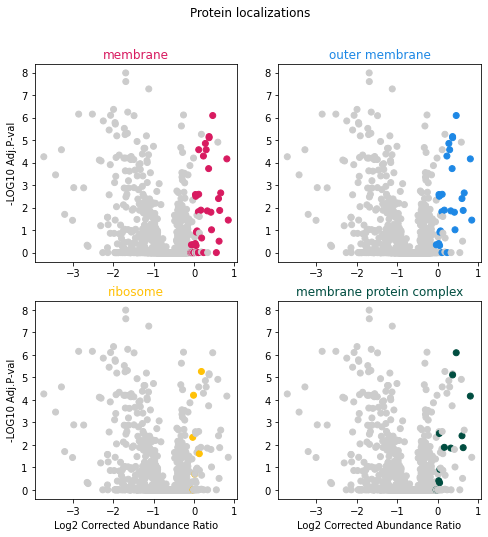

In [25]:
a = datatcl['Accession']
x = datatcl['Log2 Corrected Abundance Ratio']
y = datatcl['LOG10 Adj.P-val']

for name in names:
    datatcl['GO '+name] = [1 if datatcl.iloc[i]['Accession'] in selected_go[name] else 0 for i in range(len(datatcl))]
    #print(datatcl['GO '+name])
    #print(sum(datatcl['GO '+name]))

base_color = '#CCCCCC'

col1 = np.where(datatcl['GO '+names[0]] > 0,colors[0],base_color)
col2 = np.where(datatcl['GO '+names[1]] > 0,colors[1],base_color)
col3 = np.where(datatcl['GO '+names[2]] > 0,colors[2],base_color)
col4 = np.where(datatcl['GO '+names[3]] > 0,colors[3],base_color)

fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)

fig.suptitle('Protein localizations')

ax[0][0].scatter(x, y, c=col1)
#ax[0][0].set_xlabel('Log2 Corrected Abundance Ratio')
ax[0][0].set_ylabel('-LOG10 Adj.P-val')
ax[0][0].set_title(names[0], color=colors[0])

ax[0][1].scatter(x, y, c=col2)
#ax[0][1].set_xlabel('Log2 Corrected Abundance Ratio')
#ax[0][1].set_ylabel('-LOG10 Adj.P-val')
ax[0][1].set_title(names[1], color=colors[1])

ax[1][0].scatter(x, y, c=col3)
ax[1][0].set_xlabel('Log2 Corrected Abundance Ratio')
ax[1][0].set_ylabel('-LOG10 Adj.P-val')
ax[1][0].set_title(names[2], color=colors[2])

ax[1][1].scatter(x, y, c=col4)
ax[1][1].set_xlabel('Log2 Corrected Abundance Ratio')
#ax[1][1].set_ylabel('-LOG10 Adj.P-val')
ax[1][1].set_title(names[3], color=colors[3])

plt.show()